In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using DynamicAxisWarping
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall

In [3]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

PyObject <module 'pandas' from '/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/pandas/__init__.py'>

In [4]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

cond = false

false

In [5]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

In [49]:
data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData_1.jld2"));

In [50]:
max_gen = 75000

75000

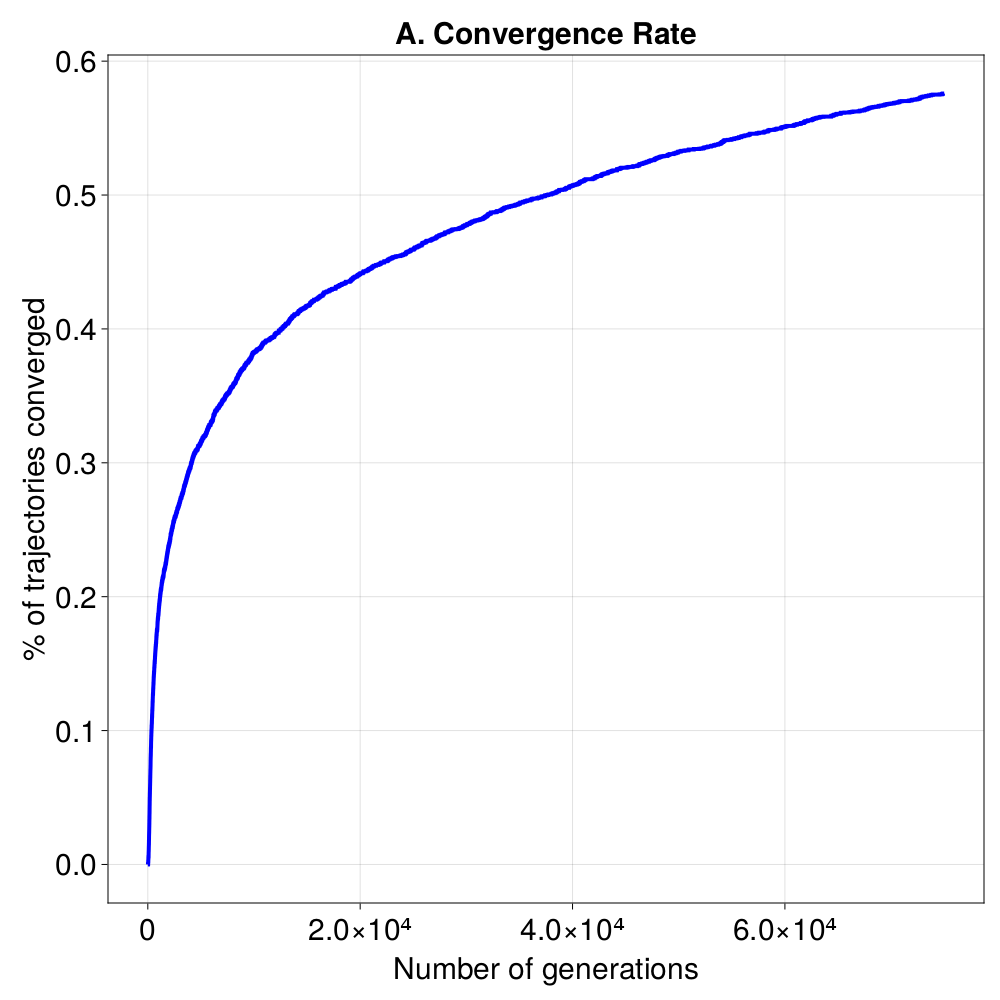

In [51]:
conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

cond_save(plotsdirx("Experiment_1","ConvergenceRates.png"),fig,cond)

fig

In [52]:
fundamental_networks_dyn_cell = pmap(nt->get_rel_dyn_vector(nt[1],nt[2],n_steps,save_id),zip(fundamental_networks,fundamental_networks_t2s));
fundamental_networks_dyn_av = pmap(nt->get_av_dyn_vector(nt[1],nt[2],n_steps,n_segments),zip(fundamental_networks,fundamental_networks_t2s));

fund_X_cell = reduce(hcat,fundamental_networks_dyn_cell)
fund_X_av = reduce(hcat,fundamental_networks_dyn_av);

In [53]:
sim_m = copy(data["fund_dmat_cell"])
conv = copy(data["converged"]);

n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

end_networks = map(v->v[:,end],data["geno_traj"]);

mind_class =  map(x->fundamental_labels[x[2]],argmin(sim_m,dims =2)) 

incl_top = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks)) |> transpose |> collect;

dyn_top_mind = zeros(Int,length(end_networks),length(fundamental_topologies))

top_assignment_mind = map(x->fund_top_ndict[x],mind_class)

for (net,t) in enumerate(top_assignment_mind)
    dyn_top_mind[net,t] = 1
end

########

class_labels = map(x->fund_top_dict[x],determine_class(incl_top,dyn_top_mind))[conv];


In [54]:
countmap(class_labels)

Dict{String, Int64} with 5 entries:
  "bistable"      => 326
  "feed_forward"  => 25
  "classical"     => 1428
  "mutual_inh"    => 33
  "No assignment" => 1067

In [14]:
class_labels_u = unique(class_labels);

In [15]:
color_name = ["purple","red","green","yellow","blue","pink"]

color_dict = Dict(i=>color_name[fund_top_ndict[i]+1] for i in class_labels_u)

Dict{String, String} with 4 entries:
  "bistable"      => "blue"
  "feed_forward"  => "red"
  "classical"     => "pink"
  "No assignment" => "purple"

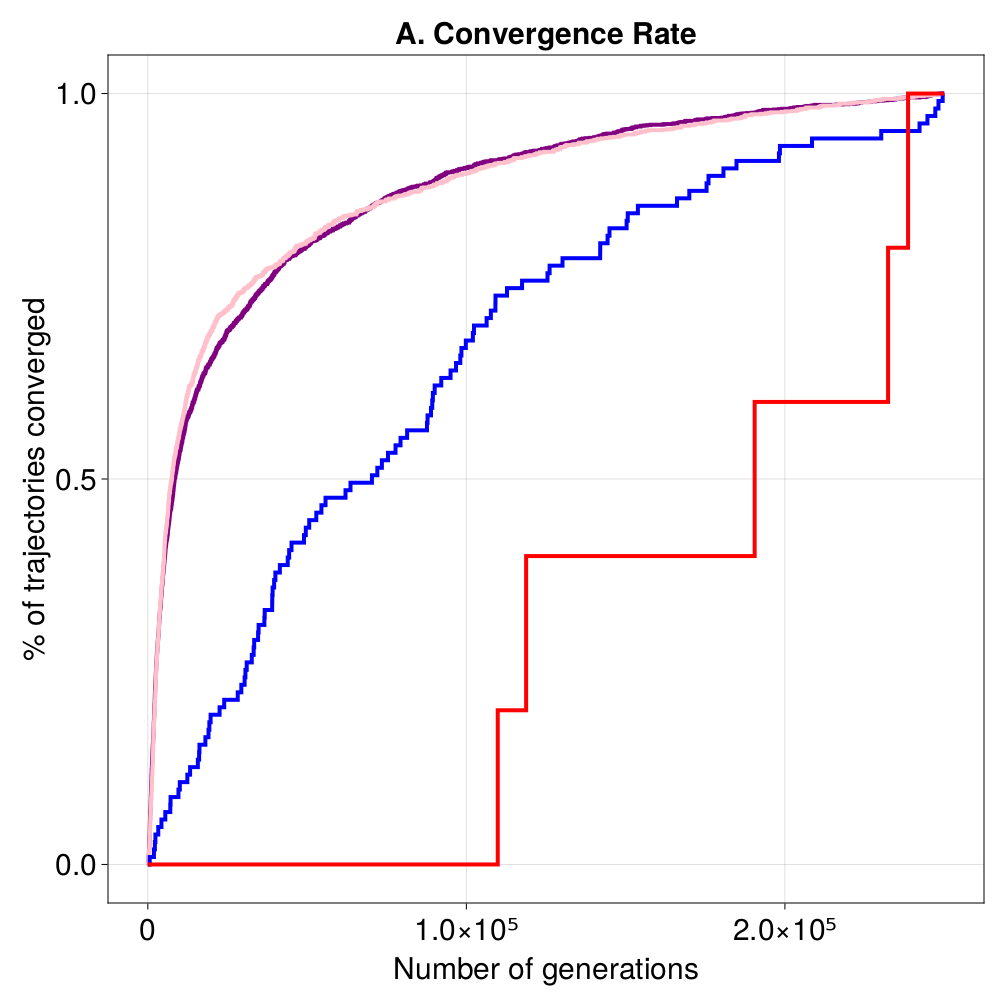

In [16]:
conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

for cl in unique(class_labels)

    cl_id = findall(x->x==cl,class_labels)

    cum_conv = [sum(conv_time[conv][cl_id] .< i)/length(cl_id) for i in 1:max_gen];

    CairoMakie.lines!(ax,cum_conv,label = cl,color = color_dict[cl],linewidth = 4.)

end

cond = true

cond_save(plotsdirx("Experiment_1","ConvergenceRatesByMech.png"),fig,cond)

fig

    

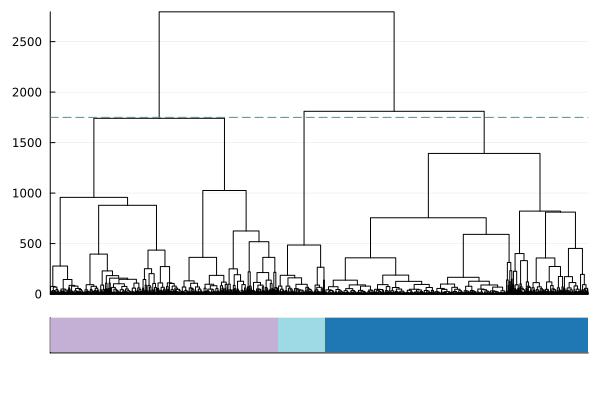

In [17]:
cu_thresh =  1750

hc1 = hclust(dmat_av[conv,conv],linkage = :ward)

clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(clust_labels[hc1.order],(1,n_traj)),colorbar=false,yticks = false,xticks = false,colormap = cgrad(:tab20,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [18]:
fitness_traj_b = copy(data["fitness_traj"])[conv];

fitness_traj = map(t->map(x->x[2]+x[1],t),fitness_traj_b);

In [19]:
conv_time = map(x->length(x),fitness_traj_b) 
conv_time_n = conv_time / maximum(conv_time);

In [20]:
# CairoMakie.boxplot(clust_labels, conv_time)

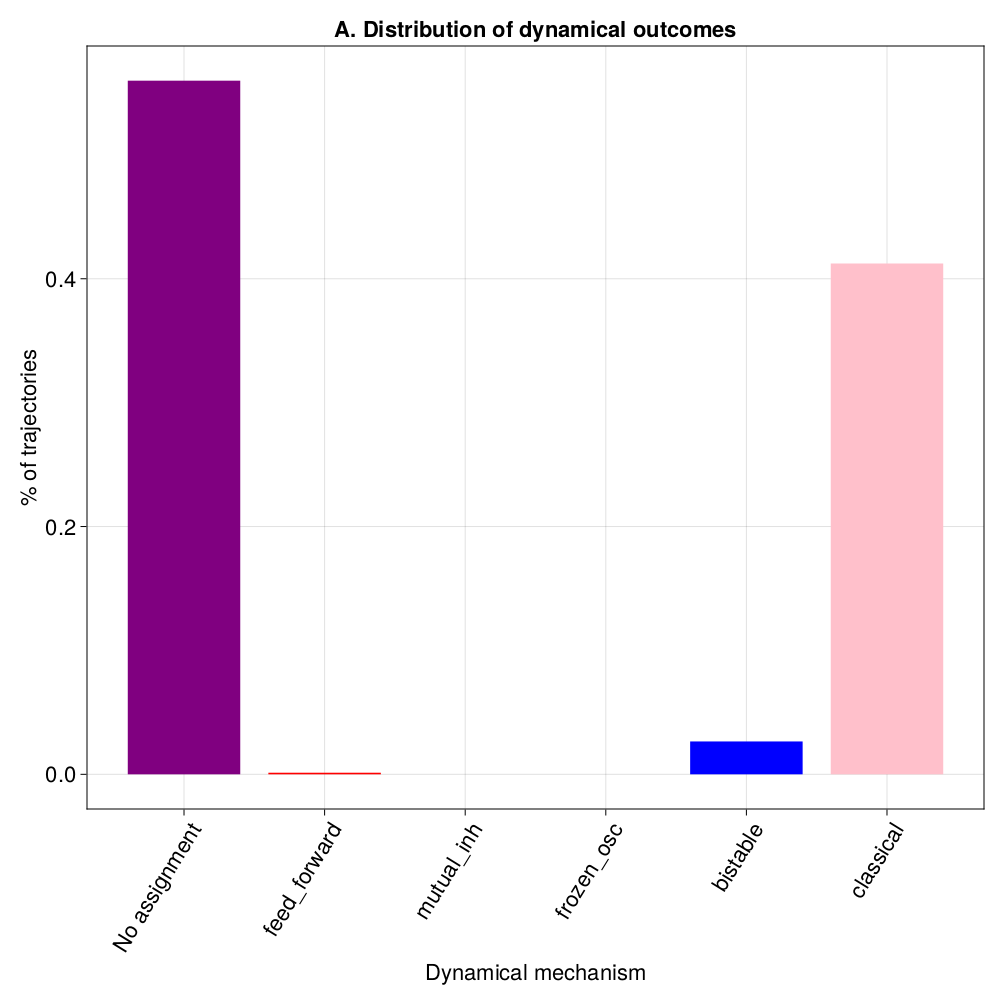

In [21]:
fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 22.)

ax = Axis(fig[1,1],title = "A. Distribution of dynamical outcomes",xlabel = "Dynamical mechanism",ylabel = "% of trajectories")

count_v_list = []
dodge_list = []
pos_list = []
color_list = []

for (n,i) in enumerate([class_labels])

    r_ms2_cm = countmap(i)

    count_v = zeros(length(fundamental_topologies)+1)

    for (i,nm) in enumerate(fundamental_topologies)
        if haskey(r_ms2_cm,nm)
            count_v[i+1] = r_ms2_cm[nm]
        else
            count_v[i+1] = 0
        end
    end

    if haskey(r_ms2_cm,"No assignment")
        count_v[1] = r_ms2_cm["No assignment"]
    else
        count_v[1] = 0
    end

    count_v = count_v ./ sum(count_v)

    # r_ms3 = reduce(vcat,r[:fitness_delta]);

    push!(count_v_list,count_v)
    push!(dodge_list,[Int(n) for _ in 1:length(count_v)])
    push!(pos_list,collect(1:length(count_v)))
    push!(color_list,[cp[x] for x in 1:length(count_v)])

    # CairoMakie.density!(ax3,filter(x->x < 1,r_ms3), color = (cp[fund_top_ndict[i]+1],0.5),offset =  -(fund_top_ndict[i]+1))
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax,xs,ys,dodge = dodge,color = bar_cl)

ax.xticks = (1:6,[fund_top_dict[x] for x in 0:5])

# ax.xticklabelcolor = (1:6,[cp[x+1] for x in 0:5])

ax.xticklabelrotation = 45

cond_save(plotsdirx("Experiment_1","DynOutcomes.png"),fig,cond)

fig

In [22]:
count_v_list

1-element Vector{Any}:
 [0.5598763842389904, 0.0012876641771825909, 0.0, 0.0, 0.02652588204996137, 0.41231006953386556]

In [23]:
n_bin = 5

h_conv = fit(Histogram, conv_time, nbins = n_bin; closed = :left) 

conv_binned = map(c->StatsBase.binindex(h_conv, c),conv_time)

countmap(conv_binned)

Dict{Int64, Int64} with 5 entries:
  5 => 90
  4 => 117
  2 => 385
  3 => 207
  1 => 3084

In [24]:
conv_enames = [string(Int(h_conv.edges[1][i])) * ":" * string(Int(h_conv.edges[1][i+1])) for i in 1:length(h_conv.edges[1])-1]

5-element Vector{String}:
 "0:50000"
 "50000:100000"
 "100000:150000"
 "150000:200000"
 "200000:250000"

In [25]:
d = pd.DataFrame(Dict("ConvTime" => map(x->conv_enames[x],conv_binned), "Topology" => class_labels));

In [26]:
color_name = ["purple","red","green","yellow","blue","pink"]
color_dict = Dict(i=>color_name[fund_top_ndict[i]+1] for i in class_labels_u)

props = key -> Dict("color" => color_dict[key[2]])
labelizer = key -> ""

fig = statmod.mosaic(d,["ConvTime","Topology"],properties = props,labelizer = labelizer,label_rotation = 90)

# plt.show()

(PyObject <Figure size 1280x960 with 3 Axes>, Dict{Any, Any}(("150000:200000", "classical") => (0.9428340226123929, 0.49411864263349414, 0.02954053112360056, 0.39773208090039774), ("50000:100000", "bistable") => (0.8407260406093934, 0.9324075264669324, 0.09720602121868575, 0.06429214350006432), ("100000:150000", "No assignment") => (0.7835600632217862, 0.0, 0.05226401660329348, 0.5213564834744344), ("50000:100000", "classical") => (0.8407260406093934, 0.5664995070935664, 0.09720602121868575, 0.36260768934036264), ("200000:250000", "bistable") => (0.9772765145203072, 0.8976897689768978, 0.02272348547969281, 0.07700770077007696), ("100000:150000", "classical") => (0.7835600632217862, 0.5246568135074376, 0.05226401660329348, 0.3874300473525613), ("200000:250000", "feed_forward") => (0.9772765145203072, 0.9779977997799779, 0.02272348547969281, 0.022002200220022035), ("0:50000", "classical") => (0.0, 0.5635217218219876, 0.7786581024374725, 0.41543064812317815), ("50000:100000", "feed_forwar

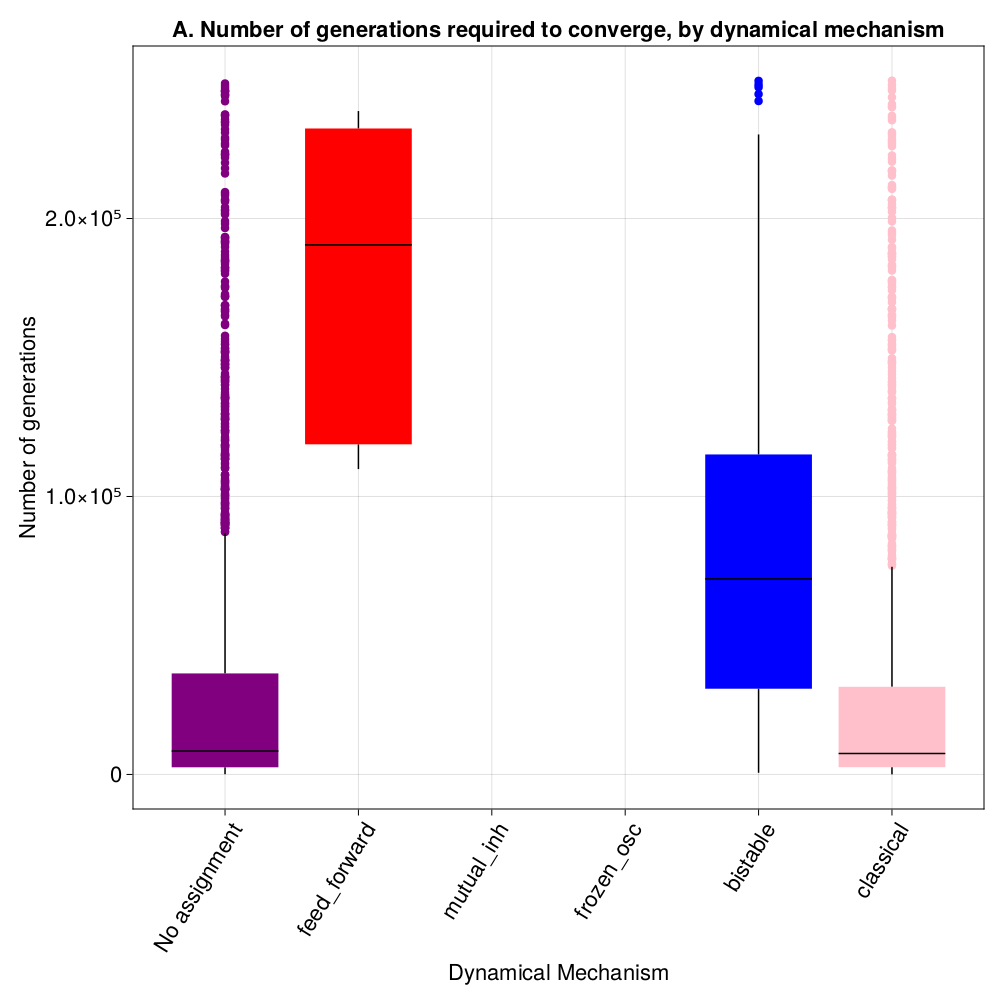

In [27]:
fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 22.)

ax = Axis(fig[1,1],title = "A. Number of generations required to converge, by dynamical mechanism",xlabel = "Dynamical Mechanism",ylabel = "Number of generations")

CairoMakie.boxplot!(ax,map(x->fund_top_ndict[x],class_labels), conv_time, color = map(x->cp[fund_top_ndict[x]+1],class_labels))

ax.xticks = (0:5,[fund_top_dict[x] for x in 0:5])

ax.xticklabelrotation = 45

cond_save(plotsdirx("Experiment_1","ConvergenceRateComparison.png"),fig,cond)

fig

In [28]:
geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

In [29]:
function get_mutant_n_dist(g_traj)
    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    return sum(g_traj_diff .!= 0.,dims = 1)[1,:]
end

function get_mutant_dist(g_traj)
    g_traj_diff = (g_traj[:,2:end] .- g_traj[:,1:end-1]) ./ map(x-> x == 0 ? 1. : x, g_traj[:,1:end-1])
    
    return [filter(x->x .!= 0.,v) for v in eachcol(g_traj_diff)]
end

function get_fitness_delta(f_traj)
    f_traj_diff = f_traj[2:end] .- f_traj[1:end-1]
    return f_traj_diff
end

function get_mutation_id(g_traj)

    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    mut_id = [findall(x-> x .!= 0, y) for y in eachcol(g_traj_diff)]

    return mut_id
end


weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

In [30]:
initial_fitness = fitness_traj[1][1]

-0.9985165945734575

In [31]:
ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [32]:
mut_types = data["mut_type"][conv];
mut_choices = data["mut_choices"][conv]

dmc_re = map(mct->map(mc->map(x->ci_indices_dict[x],mc),mct),mut_choices)

dmc_re_sp = map(mct->map(x->sortperm(x),mct),dmc_re)

mut_choices_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(dmc_re,dmc_re_sp)];

mut_types_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(mut_types,dmc_re_sp)];

In [33]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),fitness_traj)))

n_bin = 10

hist_edges = zeros(n_bin+1)

hist_edges[1] = initial_fitness

hist_edges[2:n_bin] .= LinRange(initial_fitness+eps(),0.9,n_bin-1) |> collect

hist_edges[n_bin+1] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),unique(traj)),fitness_traj);

In [34]:
clust_labels = copy(class_labels);

In [35]:
mut_id = map(x->get_mutation_id(unique(x,dims = 2)),geno_traj);

mut_id_labels = map(v->map(x->weight_names[x],v),mut_id);

mut_id_labels = map(v->map(x->(n_mut=length(x),mut_id_name=join(map(i->weight_names[i],x),"|"),mut_id=x),v),mut_id);

mut_dist = map(x->get_mutant_dist(unique(x,dims = 2)),geno_traj);

fitness_delta = map(x->get_fitness_delta(unique(x)),fitness_traj);

actual_fitness = map(x->unique(x)[1:end-1],fitness_traj);

mut_id_label_type = [[(mut_type=mut_typ,midl...) for (mut_typ,midl) in zip(mut_types_ro[i],mut_id_labels[i])] for i in 1:length(mut_id_labels)];

mut_id_size_label = [[(mut_size=mut_size,midl...) for (mut_size,midl) in zip(mut_dist[i],mut_id_label_type[i])] for i in 1:length(mut_id_label_type)];

mut_id_size_label_af = [[(fitness=fitness,midl...) for (fitness,midl) in zip(actual_fitness[i],mut_id_size_label[i])] for i in 1:length(mut_id_size_label)];

mut_id_size_label_fb = [[(fitness_bin=fb,midl...) for (fb,midl) in zip(fitness_routes[i],mut_id_size_label_af[i])] for i in 1:length(mut_id_size_label_af)];

mut_id_size_label_fb_ft = [[(fitness_delta=fd,midl...) for (fd,midl) in zip(fitness_delta[i],mut_id_size_label_fb[i])] for i in 1:length(mut_id_size_label_fb)];

mut_id_size_label_fb_cc = [[(cluster_id=clust_labels[i],midl...) for midl in mut_id_size_label_fb_ft[i]] for i in 1:length(mut_id_size_label_fb_ft)];

mut_info = [[(traj_id=i,midl...) for midl in mut_id_size_label_fb_cc[i]] for i in 1:length(mut_id_size_label_fb_cc)];

all_mut_info = reduce(vcat,mut_info);

In [36]:
function condition_data(return_var,condition_var,condition_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

function condition_data_incl(return_var,condition_var,condition_values,incl_var,incl_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]) & all([value ∈ x[var] for (var,value) in zip(incl_var,incl_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

condition_data_incl (generic function with 1 method)

In [37]:
class_labels_u = unique(class_labels)

4-element Vector{String}:
 "No assignment"
 "classical"
 "bistable"
 "feed_forward"

In [38]:
r = condition_data((:mut_id,:cluster_id),[:fitness_bin,:n_mut],[1,1],all_mut_info);

mut_id = map(x->weight_names[x],reduce(vcat,r[:mut_id]))

clust_id =r[:cluster_id]

d = pd.DataFrame(Dict("Weight" => mut_id, "Topology" => clust_id))

props = key -> Dict("color" => color_dict[key[2]])
labelizer = key -> ""

fig = statmod.mosaic(d,["Weight","Topology"],properties = props,labelizer = labelizer,statistic = true,label_rotation = 90)

plt.show()

dchi = pd.crosstab(d["Weight"],d["Topology"]).values


2×4 Matrix{Int64}:
 363  53  566  0
 908  15  445  1

In [39]:
props = key -> Dict("color" => color_dict[key[2]])
labelizer = key -> ""

#312 (generic function with 1 method)

In [40]:
# d_all = pd.DataFrame(Dict("Weight" => ["All" for _ in mut_id], "Topology" => clust_id))

# d_en = pd.concat([d,d_all])

In [41]:
fig = statmod.mosaic(d,["Weight","Topology"],properties = props,labelizer = labelizer,statistic = true,label_rotation = 90)

plt.show()

In [42]:
dchi = pd.crosstab(d["Weight"],d["Topology"]).values

2×4 Matrix{Int64}:
 363  53  566  0
 908  15  445  1

In [40]:
ChisqTest(dchi)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.00161887, 0.0381333, 0.0260817, 0.00755471, 0.0402918, 0.0591785, 0.0260817, 0.107565, 0.0402918, 0.0311182  …  5.30107e-5, 0.0012487, 0.000854062, 0.000247383, 0.00131938, 0.00193784, 0.000854062, 0.00352227, 0.00131938, 0.00101898]
    point estimate:          [0.00190386, 0.039029, 0.0214184, 0.00856735, 0.0428367, 0.065683, 0.0280819, 0.0994764, 0.0404569, 0.0304617  …  0.0, 0.000951928, 0.000951928, 0.0, 0.000475964, 0.00190386, 0.000475964, 0.00285578, 0.00237982, 0.00237982]
    95% confidence interval: [(0.0, 0.01814), (0.02285, 0.05527), (0.005236, 0.03766), (0.0, 0.0248), (0.02665, 0.05907), (0.0495, 0.08192), (0.0119, 0.04432), (0.08329, 0.1157), (0.02427, 0.05669), (0.01428, 0.0467)  …  (0.0, 0.01624), (0.0, 0.01719), (0.0, 0.01719), (0.0, 0.01624), (0.0, 0.01671), (0.0, 0.01814), (0.0, 0.01671), (0.0, 0.01909), (0.0,

In [43]:
# function get_dynamical_traj(gt_traj::Matrix{Float64},t2s_traj::Vector{Float64})
#     # all_dyn_networks = [get_av_dyn_vector(reshape(nt[1],(3,4)) |> collect,nt[2],n_steps,n_segments) for nt in zip(eachcol(gt_traj),t2s_traj)]
#     all_dyn_networks = [get_rel_dyn_vector(reshape(nt[1],(3,4)) |> collect,nt[2],n_steps,save_id) for nt in zip(eachcol(gt_traj),t2s_traj)]
#     # if all(map(x->size(x,1) == 96,all_dyn_networks))
#     #     return reduce(hcat,all_dyn_networks)
#     # else
#     #     return NaN
#     # end

#     if all(map(x->size(x,1) == 72,all_dyn_networks))
#         return reduce(hcat,all_dyn_networks)
#     else
#         return NaN
#     end
# end

In [44]:
r = get_dynamical_traj(data["geno_traj"][2],data["t2s_traj"][1])

UndefVarError: UndefVarError: get_dynamical_traj not defined

In [45]:
dyn_av = pmap(nt->get_dynamical_traj(nt[1],nt[2]),zip(data["geno_traj"][conv][1:500],data["t2s_traj"][conv][1:500]));

CapturedException: UndefVarError: get_dynamical_traj not defined
Stacktrace:
 [1] (::var"#314#315")(nt::Tuple{Matrix{Float64}, Vector{Float64}})
   @ Main ~/Documents/GRNEvoContingency/notebooks/Experiment 1/Exp1_initial_analysis_dyn_traj.ipynb:1
 [2] (::Base.var"#929#934"{var"#314#315"})(r::Base.RefValue{Any}, args::Tuple{Tuple{Matrix{Float64}, Vector{Float64}}})
   @ Base ./asyncmap.jl:100
 [3] macro expansion
   @ ./asyncmap.jl:234 [inlined]
 [4] (::Base.var"#945#946"{Base.var"#929#934"{var"#314#315"}, Channel{Any}, Nothing})()
   @ Base ./task.jl:484

In [46]:
valid = findall(x->typeof(x)!= Float64,dyn_av);

UndefVarError: UndefVarError: dyn_av not defined

In [47]:
# fitness_sample = map(x-> unique(x.+ 1),fitness_traj[1:100][valid])

# color_fitness = reduce(vcat,fitness_sample);

In [48]:
Xt = reduce(hcat,dyn_av[valid]);

UndefVarError: UndefVarError: dyn_av not defined

Calculating PHATE...
  Running PHATE on 26317 observations and 72 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 23.30 seconds.
    Calculating affinities...
    Calculated affinities in 4.57 seconds.
  Calculated graph and diffusion operator in 28.28 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 9.67 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.06 seconds.
  Calculated landmark operator in 17.02 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 7.91 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.71 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.29 seconds.
Calculated PHATE in 57.21 seconds.


/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/phate/phate.py:186: FutureWarning: k is deprecated. Please use knn in future.
  warnings.warn("k is deprecated. Please use knn in future.", FutureWarning)
/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 121771 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


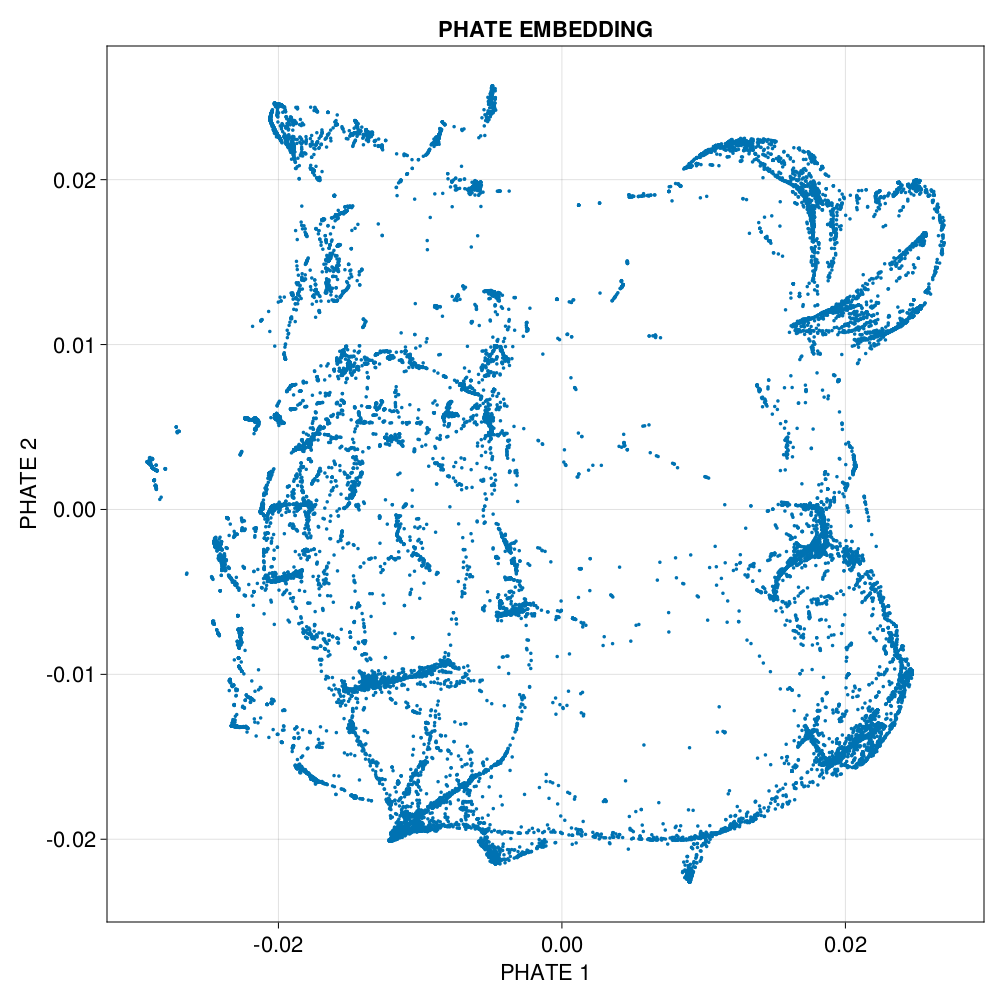

In [102]:
phate = pyimport("phate")

phate_op = phate.PHATE(k = 250,n_jobs = -2)

rescale(A; dims=1) = (A .- mean(A, dims=dims)) ./ max.(std(A, dims=dims), eps())

# X = rescale(data["dmat_X_av"][:,conv] |> transpose |> collect, dims=1);

X = Xt |> transpose |> collect

phate_pheno_g3 = phate_op.fit_transform(X);

fig = CairoMakie.Figure(resolution = (1000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING")

c = CairoMakie.scatter!(ax,phate_pheno_g3,markersize = 5.)

fig